# Deep Learning Term Project for ECG (DIL700)

# Iteration 3

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.utils import class_weight
import warnings
import os
from general_functions import *
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint


warnings.filterwarnings('ignore')

## Loading Dataset

Collect all the data from the csv files

In [2]:
# # Original data

train_df=combine_csv_files_to_df('./Dataset_mitbih/Training/')
test_df=combine_csv_files_to_df('./Dataset_mitbih/Testing/')
# Put together the training and testing
full_df=pd.concat([train_df,test_df],ignore_index=True)

# Synthetic data

synthetic_train_df = pd.read_csv('./Dataset_mitbih/Synthetic/mitbih_with_syntetic_train.csv')
synthetic_train_df = synthetic_train_df.iloc[:, :-1]
synthetic_train_df.rename(columns={'class': 187}, inplace=True)
synthetic_test_df = pd.read_csv('./Dataset_mitbih/Synthetic/mitbih_with_syntetic_test.csv')
synthetic_test_df = synthetic_test_df.iloc[:, :-1]
synthetic_test_df.rename(columns={'class': 187}, inplace=True)

# Put together the training and testing
synthetic_full_df=pd.concat([synthetic_train_df,synthetic_test_df],ignore_index=True)


## Making df equal

In [3]:
synthetic_full_df = synthetic_full_df[synthetic_full_df[187] != 'class']

synthetic_full_df.loc[synthetic_full_df[187] == '0.0', 187] = 0.0
synthetic_full_df.loc[synthetic_full_df[187] == '1.0', 187] = 1.0
synthetic_full_df.loc[synthetic_full_df[187] == '2.0', 187] = 2.0
synthetic_full_df.loc[synthetic_full_df[187] == '3.0', 187] = 3.0
synthetic_full_df.loc[synthetic_full_df[187] == '4.0', 187] = 4.0

In [4]:
print(train_df[187].unique())

[0. 1. 2. 3. 4.]


In [5]:
labels = ['Normal', 'Artial Premature', 'Premature ventricular contraction', 'Fusion', 'Paced']
labels_short =  ["N","S","V",'F',"Q"]

# Full normal data

In [6]:
print('Number of samples in data:')
print(labels[0],':', len(full_df[full_df[187]==0]))
print(labels[1],':', len(full_df[full_df[187]==1]))
print(labels[2],':', len(full_df[full_df[187]==2]))
print(labels[3],':', len(full_df[full_df[187]==3]))
print(labels[4],':', len(full_df[full_df[187]==4]))

Number of samples in data:
Normal : 90589
Artial Premature : 2779
Premature ventricular contraction : 7236
Fusion : 803
Paced : 8039


# Full normal data with synthetic data

In [7]:
print('Number of samples in data:')
print(labels[0],':', len(synthetic_full_df[synthetic_full_df[187]==0]))
print(labels[1],':', len(synthetic_full_df[synthetic_full_df[187]==1]))
print(labels[2],':', len(synthetic_full_df[synthetic_full_df[187]==2]))
print(labels[3],':', len(synthetic_full_df[synthetic_full_df[187]==3]))
print(labels[4],':', len(synthetic_full_df[synthetic_full_df[187]==4]))

Number of samples in data:
Normal : 90589
Artial Premature : 5179
Premature ventricular contraction : 7236
Fusion : 2339
Paced : 8039


# Delete class 1 3 and 5 because they are the same

In [10]:
# Delete the rows where columnn 187 is 0, 2, 4
full_df = full_df[full_df[187] != 0]
full_df = full_df[full_df[187] != 2]
full_df = full_df[full_df[187] != 4]

synthetic_full_df = synthetic_full_df[synthetic_full_df[187] != 0]
synthetic_full_df = synthetic_full_df[synthetic_full_df[187] != 2]
synthetic_full_df = synthetic_full_df[synthetic_full_df[187] != 4]



## Find synthetic data

In [11]:
# create an empty dataframe to store the non-matching rows
non_matching = pd.DataFrame(columns=full_df.columns)

# loop through each row of df1 and compare with each row of df2
for i, row1 in full_df.iterrows():
    print(i)
    match = False
    for j, row2 in synthetic_full_df.iterrows():
        if row1.equals(row2):
            match = True
            break
    if not match:
        non_matching = non_matching.append(row1)

72471
72472
72473
72474
72475
72476
72477
72478
72479
72480
72481
72482
72483
72484
72485
72486
72487
72488
72489
72490
72491
72492
72493
72494
72495
72496
72497
72498
72499
72500
72501
72502
72503
72504
72505
72506
72507
72508
72509
72510
72511
72512
72513
72514
72515
72516
72517
72518
72519
72520
72521
72522
72523
72524
72525
72526
72527
72528
72529
72530
72531
72532
72533
72534
72535
72536
72537
72538
72539
72540
72541
72542
72543
72544
72545
72546
72547
72548
72549
72550
72551
72552
72553
72554
72555
72556
72557
72558
72559
72560
72561
72562
72563
72564
72565
72566
72567
72568
72569
72570
72571
72572
72573
72574
72575
72576
72577
72578
72579
72580
72581
72582
72583
72584
72585
72586
72587
72588
72589
72590
72591
72592
72593
72594
72595
72596
72597
72598
72599
72600
72601
72602
72603
72604
72605
72606
72607
72608
72609
72610
72611
72612
72613
72614
72615
72616
72617
72618
72619
72620
72621
72622
72623
72624
72625
72626
72627
72628
72629
72630
72631
72632
72633
72634
72635
72636
7263

In [12]:
non_matching

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
72471,1.000000,0.666667,0.100457,0.036530,0.073059,0.050228,0.018265,0.105023,0.132420,0.091324,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.0
72472,0.983696,1.000000,0.331522,0.000000,0.108696,0.163043,0.130435,0.190217,0.288043,0.222826,...,0.461957,0.483696,0.500000,0.494565,0.510870,0.51087,0.505435,0.472826,0.434783,1.0
72473,1.000000,0.911504,0.216814,0.000000,0.101770,0.199115,0.176991,0.194690,0.252212,0.238938,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.0
72474,0.090498,0.126697,0.217195,0.361991,0.461538,0.556561,0.443439,0.434389,0.452489,0.511312,...,0.122172,0.131222,0.140271,0.158371,0.176471,0.20362,0.212670,0.000000,0.000000,1.0
72475,0.961111,1.000000,0.551852,0.101852,0.040741,0.085185,0.094444,0.088889,0.085185,0.070370,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107833,0.994166,1.000000,0.954492,0.913652,0.884481,0.779463,0.585764,0.390898,0.263711,0.155193,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,3.0
107834,1.000000,0.766106,0.474790,0.259104,0.163866,0.198880,0.186275,0.159664,0.152661,0.151261,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,3.0
107835,0.724000,1.000000,0.640000,0.174000,0.054000,0.052000,0.028000,0.018000,0.016000,0.018000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,3.0
107836,0.887681,1.000000,0.960145,0.500000,0.255435,0.159420,0.128623,0.110507,0.085145,0.094203,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,3.0


In [13]:
# create an empty dataframe to store the non-matching rows
non_matching1 = pd.DataFrame(columns=full_df.columns)

# loop through each row of df1 and compare with each row of df2
for i, row1 in synthetic_full_df.iterrows():
    print(i)
    match = False
    for j, row2 in full_df.iterrows():
        if row1.equals(row2):
            match = True
            break
    if not match:
        non_matching1 = non_matching1.append(row1)

1
49
55
57
74
100
109
110
140
147
151
160
168
194
204
205
229
242
243
263
264
320
326
344
350
376
397
442
459
464
471
503
515
536
540
543
564
586
653
677
682
688
690
701
724
735
736
740
742
780
804
842
853
859
873
876
888
897
899
925
938
940
951
958
963
980
982
999
1009
1016
1019
1051
1093
1115
1132
1139
1155
1156
1161
1170
1197
1217
1268
1278
1283
1285
1295
1307
1309
1311
1313
1331
1342
1351
1360
1385
1392
1394
1405
1407
1437
1453
1462
1475
1485
1489
1502
1524
1530
1572
1577
1589
1591
1600
1635
1644
1676
1685
1692
1705
1706
1718
1731
1732
1736
1763
1765
1774
1820
1822
1835
1857
1864
1874
1883
1896
1917
1918
1922
1953
1965
2003
2048
2052
2062
2064
2068
2070
2071
2106
2129
2134
2135
2143
2150
2155
2158
2174
2175
2182
2183
2197
2202
2219
2233
2236
2292
2313
2323
2332
2336
2361
2363
2371
2372
2401
2431
2438
2445
2454
2455
2457
2467
2477
2478
2486
2491
2518
2522
2544
2569
2572
2577
2582
2598
2610
2621
2659
2698
2707
2746
2749
2763
2769
2787
2799
2802
2830
2862
2872
2880
2902
2904
2938
2943

In [27]:
non_matching1

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001201,-0.000815,-0.000073,0.001334,-0.001965,0.002651,0.008061,-0.004966,-0.007939,-0.006888
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.002010,-0.004045,-0.009380,0.024993,0.002618,0.021378,-0.010180,0.004790,-0.000956,-0.003315
74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.009735,-0.020210,0.001729,-0.013439,-0.009967,-0.002184,-0.013988,-0.002457,0.018163,-0.016813
113339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.004546,-0.001618,-0.031764,0.011926,-0.003541,-0.000090,-0.007100,0.001052,0.015397,-0.042898
113342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.005815,-0.012700,0.001047,0.003051,-0.019395,-0.003977,-0.005730,0.005969,-0.008169,-0.004843
113343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.004234,0.001412,0.003267,0.013882,-0.010460,0.009486,-0.004621,-0.007470,-0.003504,-0.008257


In [15]:
full_df[187]

72471     1.0
72472     1.0
72473     1.0
72474     1.0
72475     1.0
         ... 
107833    3.0
107834    3.0
107835    3.0
107836    3.0
107837    3.0
Name: 187, Length: 3582, dtype: float64

In [16]:
synthetic_full_df[187]

1         1.0
49        1.0
55        1.0
57        3.0
74        3.0
         ... 
113286    1.0
113339    3.0
113342    1.0
113343    3.0
113370    1.0
Name: 187, Length: 7518, dtype: float64

# Original visualizations

In [18]:
samples = list()
samples.append(plot_ecg_examples(full_df, 1, 5))
samples.append(plot_ecg_examples(full_df, 3, 5))


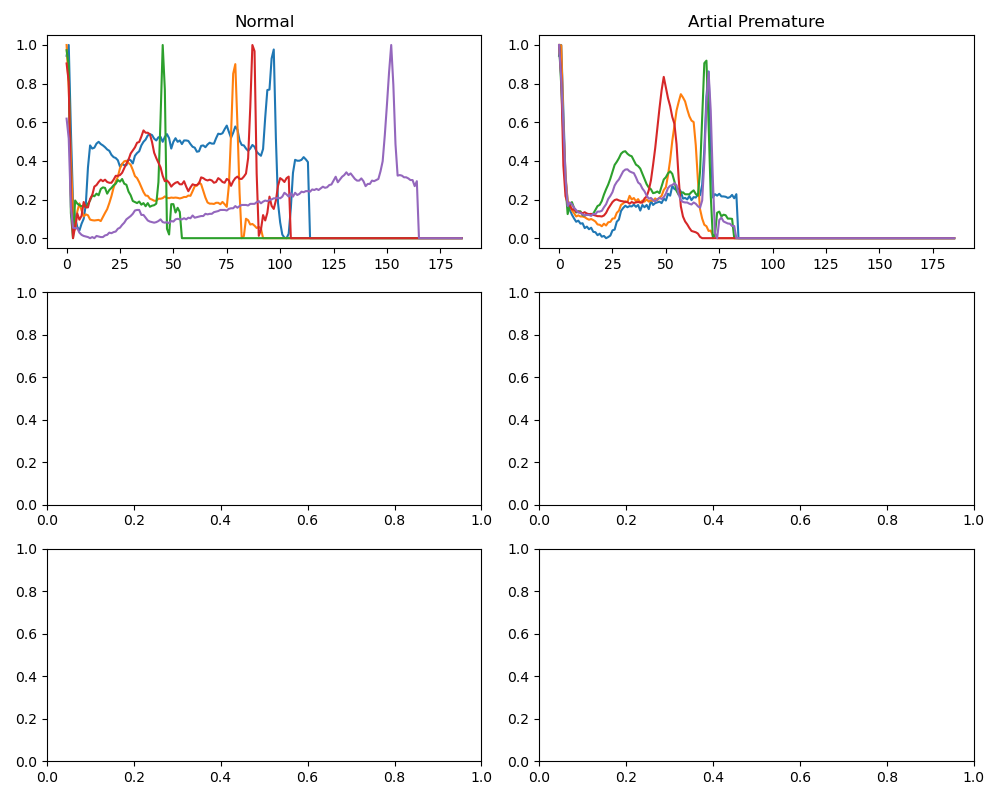

In [20]:
fig, axs = plt.subplots(3, 2, figsize=(10, 8))
titles = labels
for i in range(2):
    ax = axs.flat[i]
    ax.plot(samples[i].values[:,:-2].transpose())
    ax.set_title(titles[i])

fig.tight_layout()
plt.show()

## Heatmap of class 1 (Atrial premature)

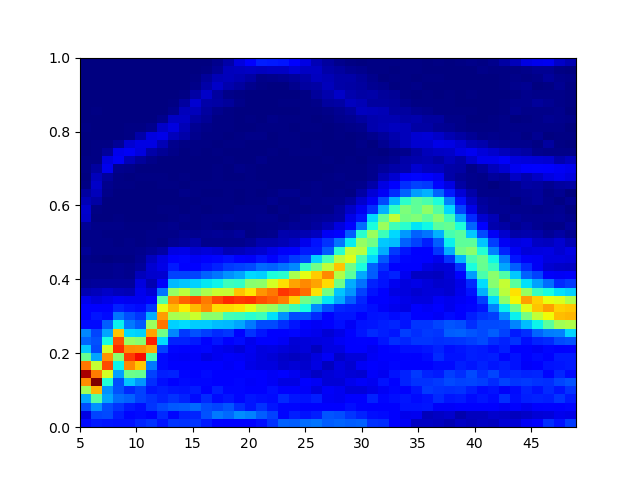

In [21]:
fig = plt.figure()
hist_class1 = plot_hist(full_df,1,50,5,45)

## Heatmap of class 3 (Fusion of ventricular and normal)

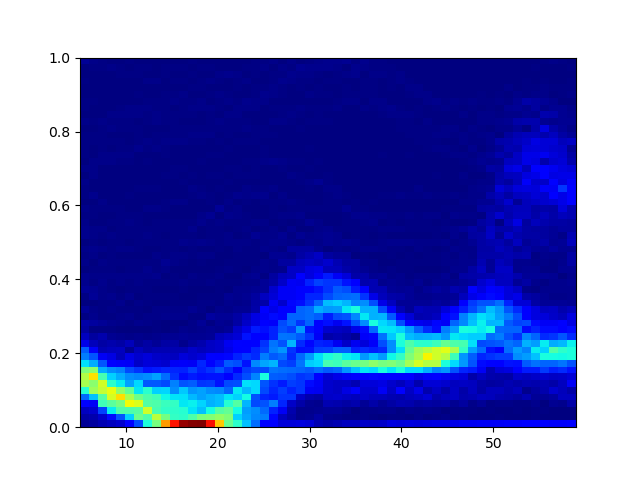

In [22]:
fig = plt.figure()
hist_class3 = plot_hist(full_df,3,60,5,55)

# Synthetic visualizations

In [23]:
samples = list()
samples.append(plot_ecg_examples(non_matching1, 1, 5))
samples.append(plot_ecg_examples(non_matching1, 3, 5))

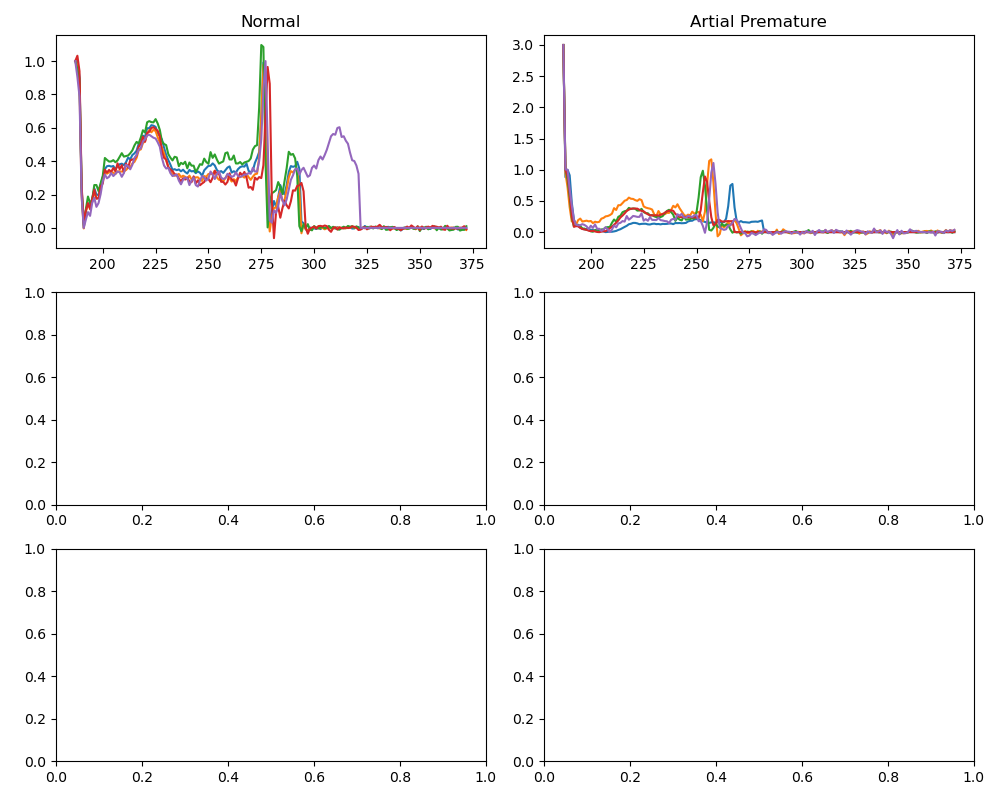

In [24]:
fig, axs = plt.subplots(3, 2, figsize=(10, 8))
titles = labels
for i in range(2):
    ax = axs.flat[i]
    ax.plot(samples[i].values[:,:-2].transpose())
    ax.set_title(titles[i])

fig.tight_layout()
plt.show()

## Heatmap of class 1 (Atrial premature)

ValueError: autodetected range of [nan, nan] is not finite

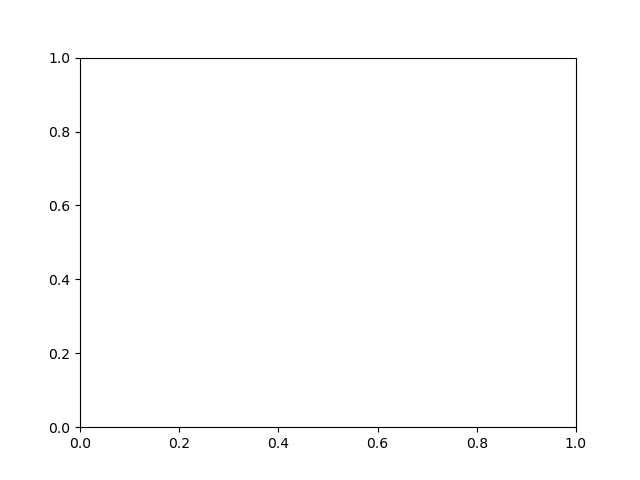

In [25]:
fig = plt.figure()
hist_class1 = plot_hist(non_matching1,1,50,5,45)

## Heatmap of class 3 (Fusion of ventricular and normal)

ValueError: autodetected range of [nan, nan] is not finite

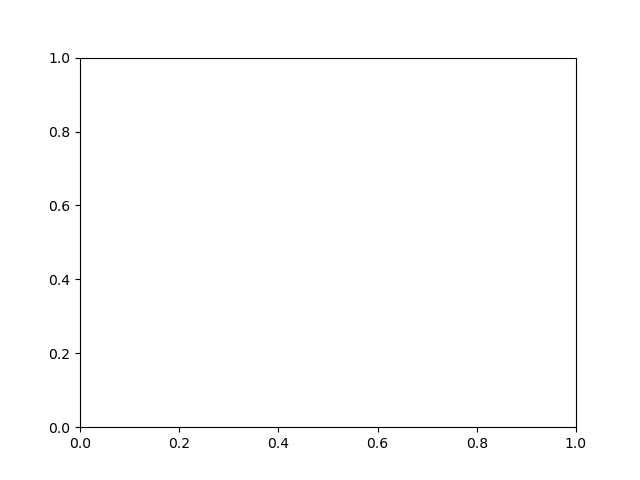

In [26]:
fig = plt.figure()
hist_class3 = plot_hist(non_matching1,3,60,5,55)